# **Projet- Reconnaissance de dechets par IA Vfinal**
*Par BRAUX Owen et MATIAS Nicolas 2024*





In [1]:
import keras
import numpy as np
import os
import sklearn
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger, LearningRateScheduler
from sklearn.model_selection import KFold
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50, VGG16, VGG19
from collections import Counter

In [2]:
#Path pour le dataset (modif avec le bon chemin)
Path_data = 'dataset_final'

#Paramètres
# Format des images (224*224 pour VGG16)
img_height = 224
img_width = 224

batch_size_model1 = 128 # Plus il est faible mieux c'est (8 est vraiment bien sans batch normalization)

epochs_model1 = 100 # mettre une grande valeur car on a un callback dans tout les cas

num_category = 4  # Nombre de classes différentes dans notre jeu de données (4 normalement pour les 4 poubelles différentes)




k_folds = 2 # C'est le nombre de plis pour la validation croisée (2 ok)

## Modèle actuel

In [3]:
# Création des générateurs d'images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.25
)

train_generator = train_datagen.flow_from_directory(
    Path_data,
    target_size=(img_height, img_width),
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    Path_data,
    target_size=(img_height, img_width),
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Charger le modèle préentrainé
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)

# First dense layer
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Second dense layer
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Second dense layer
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
predictions = Dense(num_category, activation='softmax')(x)

# Créer le modèle complet
model = Model(inputs=base_model.input, outputs=predictions)

# Geler les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Définir les callbacks
callbacks = [
    EarlyStopping(patience=20, restore_best_weights=True),
    ReduceLROnPlateau(patience=10),
    ModelCheckpoint('best_model.keras', save_best_only=True),
    CSVLogger('training_log.csv')
]

# Entraîner le modèle
history = model.fit(
    train_generator,
    epochs=epochs_model1,
    validation_data=validation_generator,
    callbacks=callbacks
)

# Fine-tuning 
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompiler le modèle avec un taux d'apprentissage plus bas
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continuer l'entraînement
history_fine_tuning = model.fit(
    train_generator,
    epochs=epochs_model1,
    validation_data=validation_generator,
    callbacks=callbacks
)

Found 1328 images belonging to 4 classes.
Found 441 images belonging to 4 classes.
Epoch 1/100


C:\Users\owenb\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.5451 - loss: 16.1391 - val_accuracy: 0.5283 - val_loss: 11.7243 - learning_rate: 0.0010
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8082 - loss: 10.5292 - val_accuracy: 0.6304 - val_loss: 9.7829 - learning_rate: 0.0010
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8323 - loss: 8.8587 - val_accuracy: 0.7551 - val_loss: 8.4874 - learning_rate: 0.0010
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8702 - loss: 7.6770 - val_accuracy: 0.7211 - val_loss: 7.4381 - learning_rate: 0.0010
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8831 - loss: 6.6298 - val_accuracy: 0.7075 - val_loss: 6.4693 - learning_rate: 0.0010
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.8991 - loss: 5.7165 - val_accuracy: 0.7007 - val_loss: 5.5948 - learning_rate: 0.0010
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.8981 - loss: 4.8803 - val_accuracy: 0.

## Graphs de notre permier modèle :

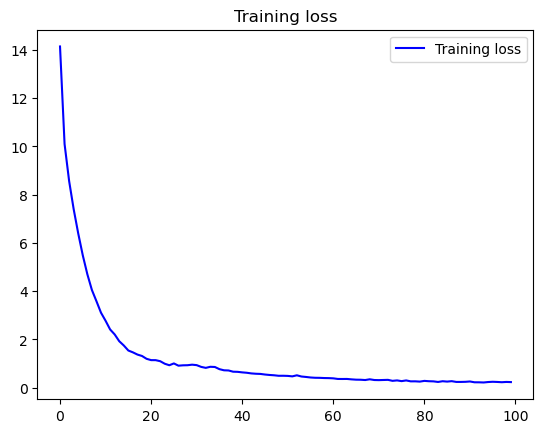

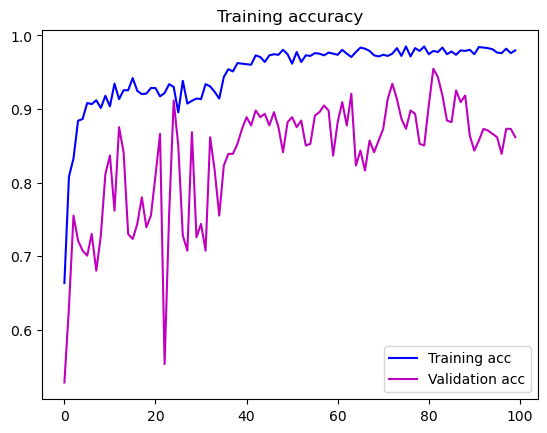

In [4]:
# Obtiers les infos du training
loss     = history.history['loss']
val_loss = history.history['val_loss']
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

# Historyplot des valeurs
plt.figure()
plt.plot(loss, 'b', label='Training loss')
#plt.plot(val_loss, 'm', label='Validation loss')
#plt.title('Training and validation loss')
plt.title('Training loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(acc, 'b', label='Training acc')
plt.plot(val_acc, 'm', label='Validation acc')
plt.title('Training and validation accuracy')
plt.title('Training accuracy')
plt.legend()
plt.show()

## Test de quelques images


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

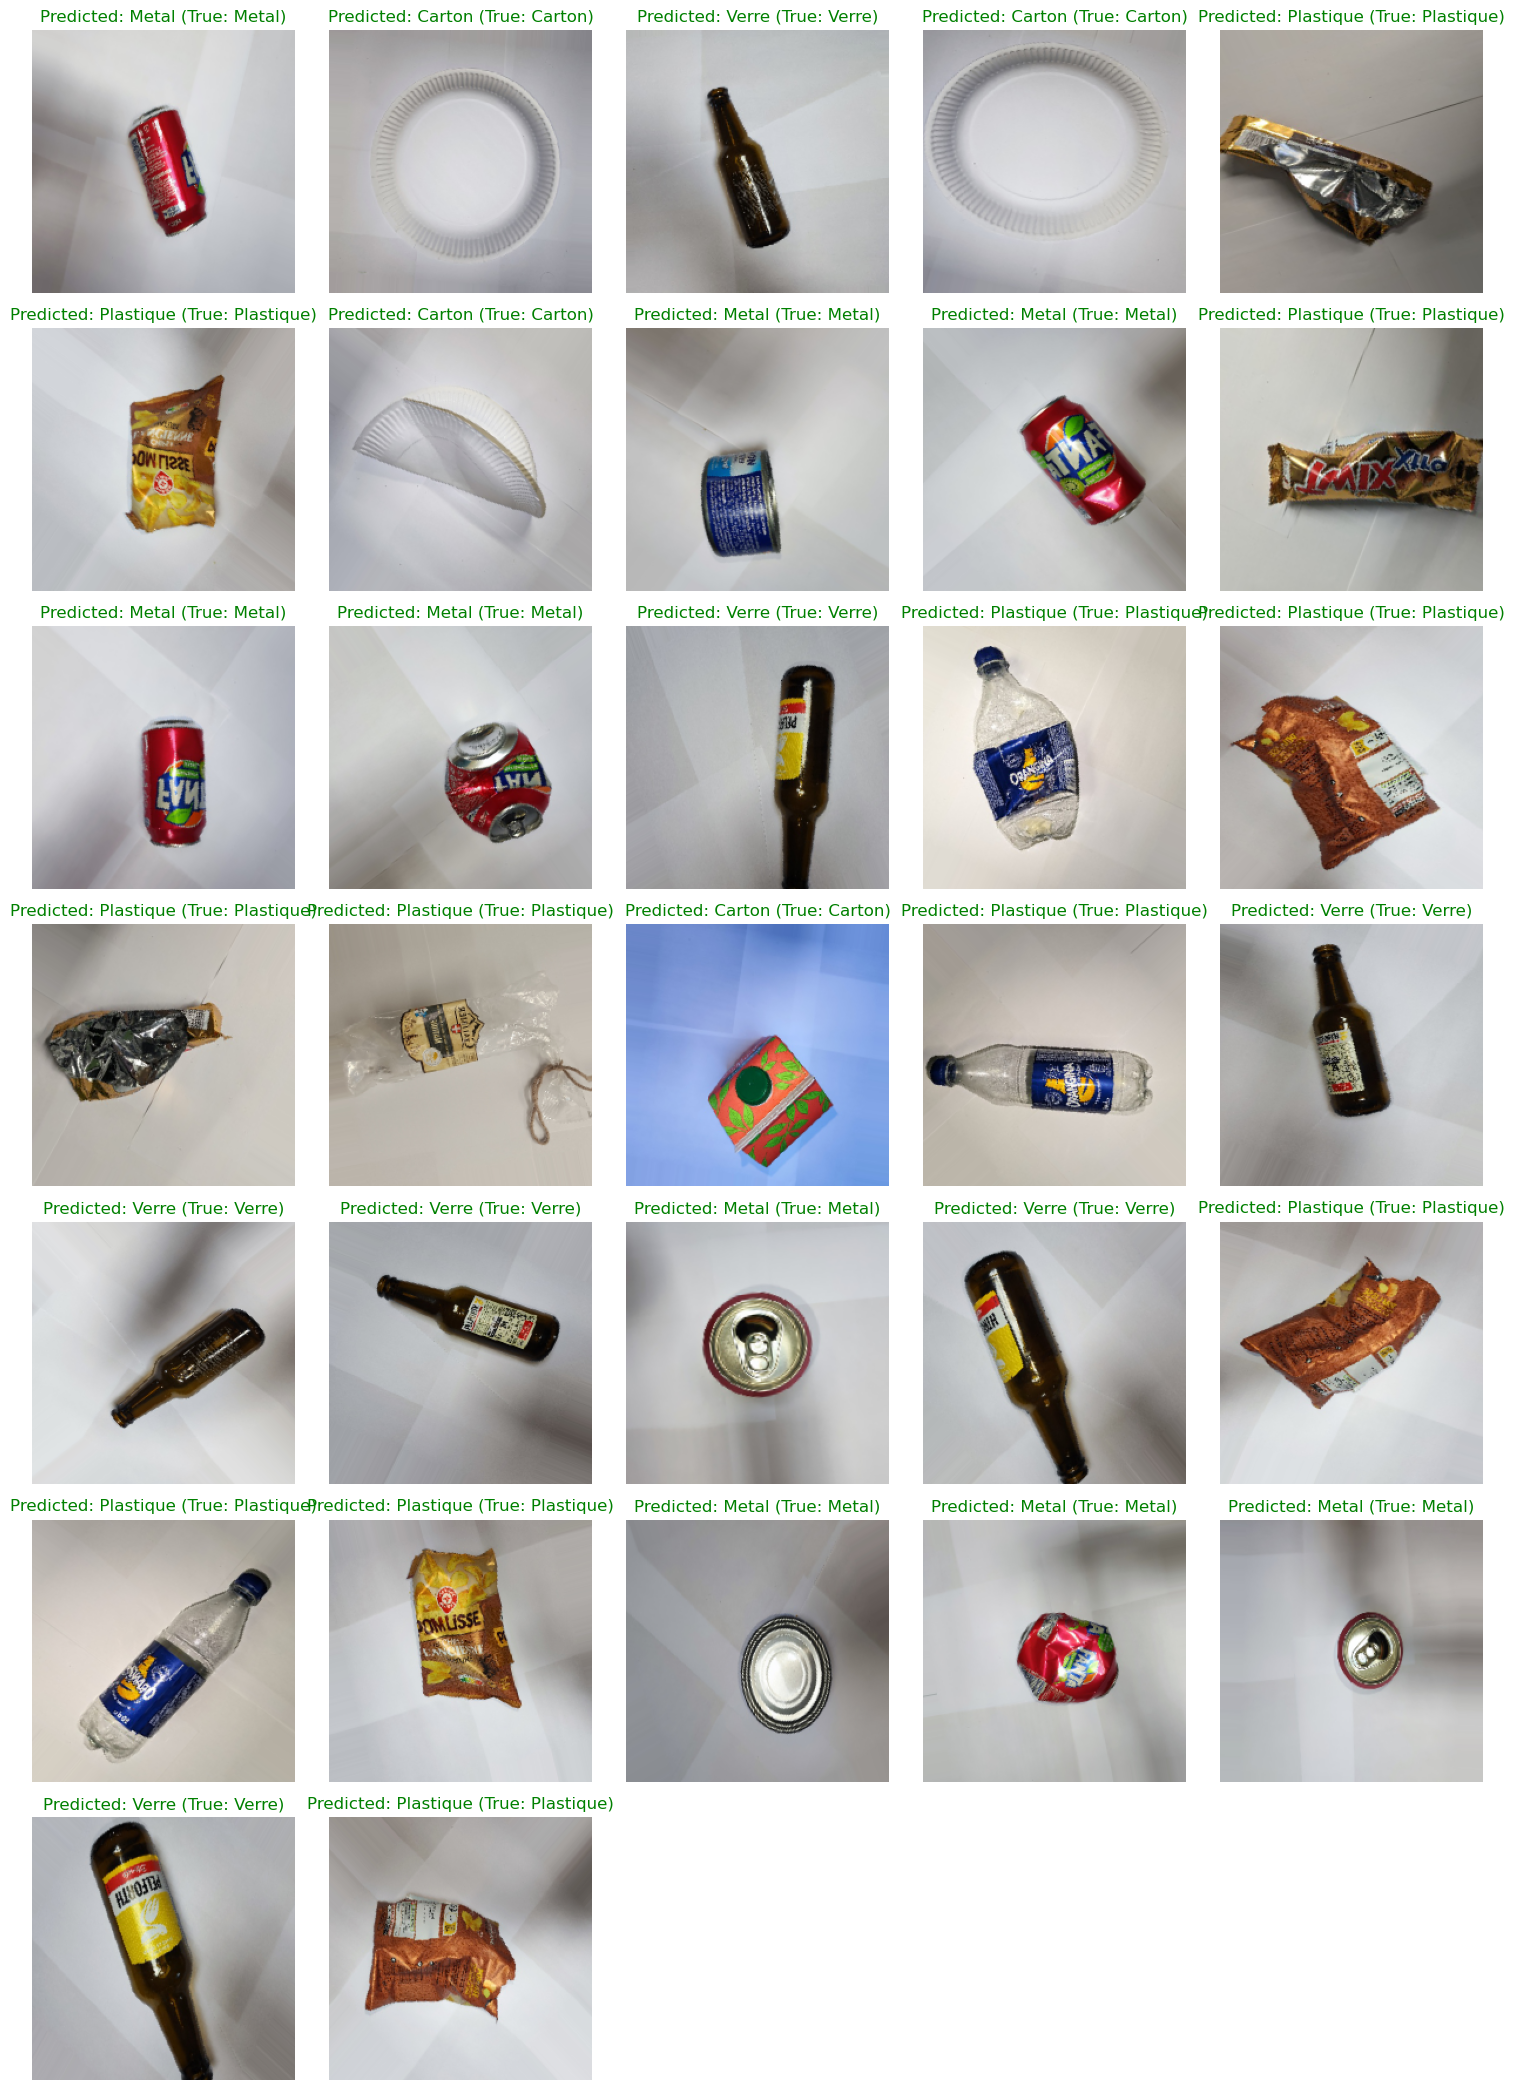

In [16]:
# Obtenir un lot d'images de validation
#images, labels = validation_generator.next()
# version qui marche tout le temps
for images, labels in validation_generator:
    break

# Obtenient la correspondance entre les indices de classe et leurs noms
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Calcule le nombre de sous-tracés 
num_images = len(images)
num_rows = (num_images + 4) // 5  # arrondi

# Crée une figure et des sous-tracés dynamiquement
fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows))

# Affiche les images et leurs libellés correspondants
for i, ax in enumerate(axes.flat):
    if i < num_images:
        prediction = model.predict(images[i][np.newaxis, ...])[0]
        predicted_label = class_names[np.argmax(prediction)]
        true_label = class_names[np.argmax(labels[i])]
        if predicted_label == true_label:
            title_color = 'green'
        else:
            title_color = 'red'
        ax.imshow(images[i])
        ax.set_title('Predicted: {} (True: {})'.format(predicted_label, true_label), color=title_color)
        ax.axis('off')
    else:
        # Cache les sous tracés restants 
        ax.axis('off')

plt.tight_layout()  # Ajuste l'espacement des sous tracés
plt.show()

In [6]:
# print les catégories du modèle
class_indices = train_generator.class_indices
general_categories = list(class_indices.keys())
print(general_categories)


['Carton', 'Metal', 'Plastique', 'Verre']


# Exportation du modèle

In [7]:
#Sauvegarde le modèle sous format h5
model.save('modelvfinal.h5')

importation du model et test

In [8]:
test_model=tf.keras.models.load_model('modelvfinal.h5')

Stats sur nos données

In [9]:
# Obtient les indices de classe et les noms des classes
class_indices = train_generator.class_indices
indices_to_labels = {v: k for k, v in class_indices.items()}
print("train generator")

# Obtenez tous les labels des échantillons
labels = train_generator.classes
total = len(labels)

# Compte le nombre d'occurrences pour le training
label_counts = Counter(labels)

# Affiche le nombre d'éléments pour le training
print(len(class_indices), "classes:")
for index, count in label_counts.items():
    proba = int((count / total) * 100)
    print(f" -{indices_to_labels[index]}, {count} éléments, {proba}%")

print("validation generator")
labels = validation_generator.classes
total = len(labels)

# Compte le nombre d'occurrences pour la validation 
label_counts = Counter(labels)

# Affichez le nombre d'éléments pour la validation 
print(len(class_indices), "classes:")
for index, count in label_counts.items():
    proba = int((count / total) * 100)
    print(f" -{indices_to_labels[index]}, {count} éléments, {proba}%")

train generator
4 classes:
 -Carton, 434 éléments, 32%
 -Metal, 357 éléments, 26%
 -Plastique, 356 éléments, 26%
 -Verre, 181 éléments, 13%
validation generator
4 classes:
 -Carton, 144 éléments, 32%
 -Metal, 119 éléments, 26%
 -Plastique, 118 éléments, 26%
 -Verre, 60 éléments, 13%
